# SKKU 2025 Quantum Challenge 
## Simulating Fluid Dynamics on a Quantum Computer

Writer: Sangyoon Woo

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from collections import Counter
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## 1. Initialization

#### 1-a)

To distinguish $M$ lattice positions during encoding, the number of qubits $n_q$ required is:

$$
n_q = \lceil \log_2 M \rceil
$$

Since the number of qubits must be an integer, we use the smallest integer greater than or equal to $\log_2 M$.

#### 1-b)

Similarly, to encode $Q$ discrete microscopic velocities (distribution functions), the number of qubits $n_d$ required is:

$$
n_d = \lceil \log_2 Q \rceil
$$

In [2]:
M = 64
Q = 3

n_q = math.ceil(math.log2(M))
n_d = math.ceil(math.log2(Q))

x_s = 32

#### 1-c)

Given these parameters:

$$
n_q = \lceil \log_2 64 \rceil = 6, \quad n_d = \lceil \log_2 3 \rceil = 2
$$

In Qiskit, we define:
- 6 qubits for the position register (`q_reg`)
- 2 qubits for the direction register (`d_reg`)

The initial position $x_s = 32$ has a value of 1.0,  
while all other positions are 0 in the NumPy array `initial_phi`.

The command `qc.initialize(initial_phi, q_reg)` encodes the initial state into the position register $|q⟩$.

In [3]:
def initialize_fd_circuit(n_q, n_d):

    q_reg = QuantumRegister(n_q, name='q')
    d_reg = QuantumRegister(n_d, name='d')

    c_q = ClassicalRegister(n_q, 'c_q') 
    c_d = ClassicalRegister(n_d, 'c_d')

    qc = QuantumCircuit(d_reg, q_reg, c_q, c_d, name='Init_phi')

    return qc, q_reg, d_reg, c_q, c_d

# `qc` serves as the foundation for creating quantum circuit components in the future.
qc, q_reg, d_reg, c_q, c_d = initialize_fd_circuit(n_q, n_d)

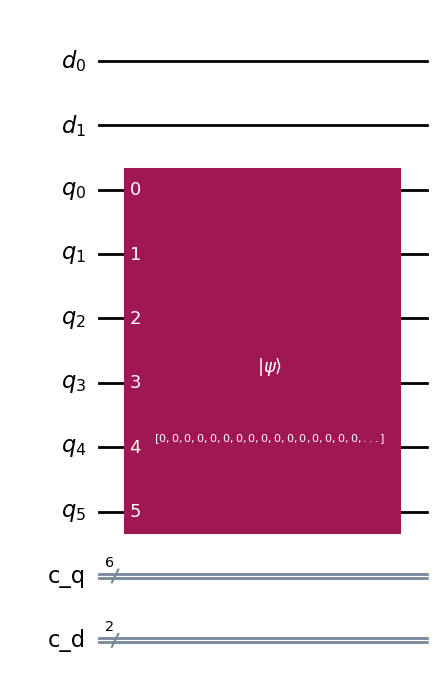

In [4]:
initial_phi = np.zeros(M)
initial_phi[x_s] = 1.0

concentration_qc = qc.copy()
concentration_qc.initialize(initial_phi, q_reg)

concentration_qc.draw('mpl')


## 2. Collision

#### 2-a)

Using the given parameters $(w, e, u, c_s)$, the calculated value of $k$ is:

$$
k = [0.667, 0.200, 0.133]
$$

The amplitudes of the quantum state correspond to the square roots of these probabilities,  
and the normalized amplitudes are:

$$
k_{amps} = [0.8165, 0.4472, 0.3651]
$$

Since $n_d = 2$, four states can be represented.  
The unused state $|11⟩$ is assigned an amplitude of 0.

The final amplitude array `k_amps` is applied to the direction register using `qc.initialize(k_amps, d_reg)`.

Calculated probability amplitude: [0.8165 0.4472 0.3651 0.    ]


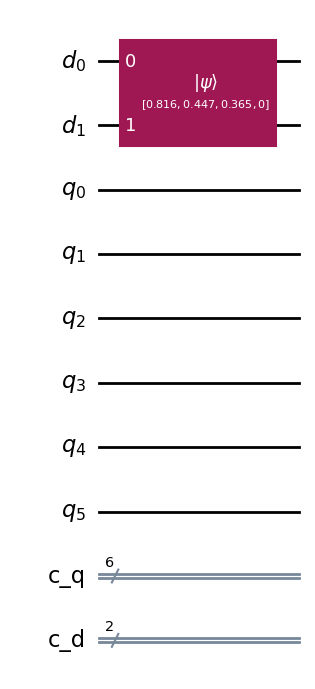

In [5]:
w = np.array([2/3, 1/6, 1/6]) 
e = np.array([0, 1, -1]) 
u = 0.2 
cs = 1 

def calculate_k(w, e, u, cs):
    k = w*(1+(e*u)/(cs**2))
    return k

def get_collision_amps(w, e, u, cs, n_d):
    k = calculate_k(w, e, u, cs)
    
    k_probabilities = np.zeros(2 ** n_d)
    k_probabilities[:len(k)] = k 

    amps = np.sqrt(k_probabilities) 

    return amps.tolist()


k_amps = get_collision_amps(w, e, u, cs, n_d)

print(f'Calculated probability amplitude: {np.round(k_amps, 4)}')

amp_qc = qc.copy()
amp_qc.initialize(k_amps, d_reg)
amp_qc.draw('mpl')

## 3. Streaming

#### 3-a)

The R operator shifts the state $|i⟩$ to $|i + 1⟩$ (right shift),  
while the L operator shifts $|i⟩$ to $|i - 1⟩$ (left shift).  
Therefore, applying both consecutively brings the state back to its original position:

$$
L(R|i⟩) = L|i + 1⟩ = |i⟩
$$

Hence, the two operators are inverses of each other:

$$
RL = LR = I
$$

#### 3-b)

The R and L operators are implemented as permutation matrices  
of size $N \times N$ (where $N = 2^{n_q}$).

Both follow this rule to construct NumPy arrays.

In [6]:
def R_matrix(n_q):
    N = 2**n_q
    R = np.zeros((N, N), dtype=complex)
    for i in range(N):
        R[(i+1) % N, i] = 1 
    return R

def L_matrix(n_q):
    N = 2**n_q
    L = np.zeros((N, N), dtype=complex)
    for i in range(N):
        L[(i-1) % N, i] = 1
    return L

#### 3-c)

The streaming operator $U_{\text{stream}}$ applies either R or L to the position register $|q⟩$ depending on the state of the direction register $|d⟩$.

In this problem, the mappings are as follows:  

$$
f_0 \rightarrow |00⟩, \; f_1 \rightarrow |01⟩, \; \text{and} \;f_2 \rightarrow |10⟩
$$

Thus, when $|01⟩$, the right-shift operator R is applied, and when $|10⟩$, the left-shift operator L is applied.

In Qiskit, these controlled operations are implemented using the `UnitaryGate` class:

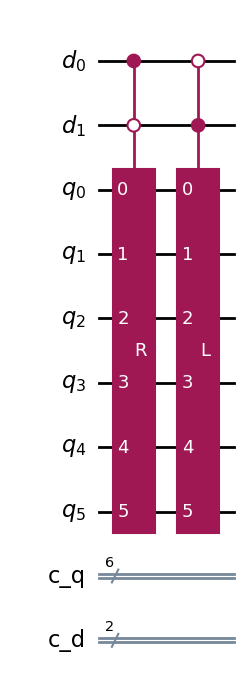

In [7]:
streaming_qc = qc.copy()

R_gate = UnitaryGate(R_matrix(n_q), label='R')
L_gate = UnitaryGate(L_matrix(n_q), label='L')

d = QuantumRegister(n_d, 'd')
q = QuantumRegister(n_q, 'q')

streaming_qc.append(R_gate.control(2, ctrl_state='01'), [d[0], d[1], *q])
streaming_qc.append(L_gate.control(2, ctrl_state='10'), [d[0], d[1], *q])

streaming_qc.draw('mpl')

## 4. Addition

In this step, Hadamard gates ($H^{\otimes 2}$) are applied to all qubits in the direction register $\ket{d}$.  

After this transformation, the amplitude of the $\ket{00}$ state ($c_{00}$) represents the sum of all directional components ($c_{00}, c_{01}, c_{10}, \ldots$).  

This corresponds to the definition of the macroscopic density:  

$$
\phi(x, t) = \sum_i f_i(x, t)
$$

Therefore, by performing **post-selection** on the $|d⟩$ register  
and selecting the **$\ket{00}$ state**, we obtain the desired macroscopic density $\phi(x, t=1)$.

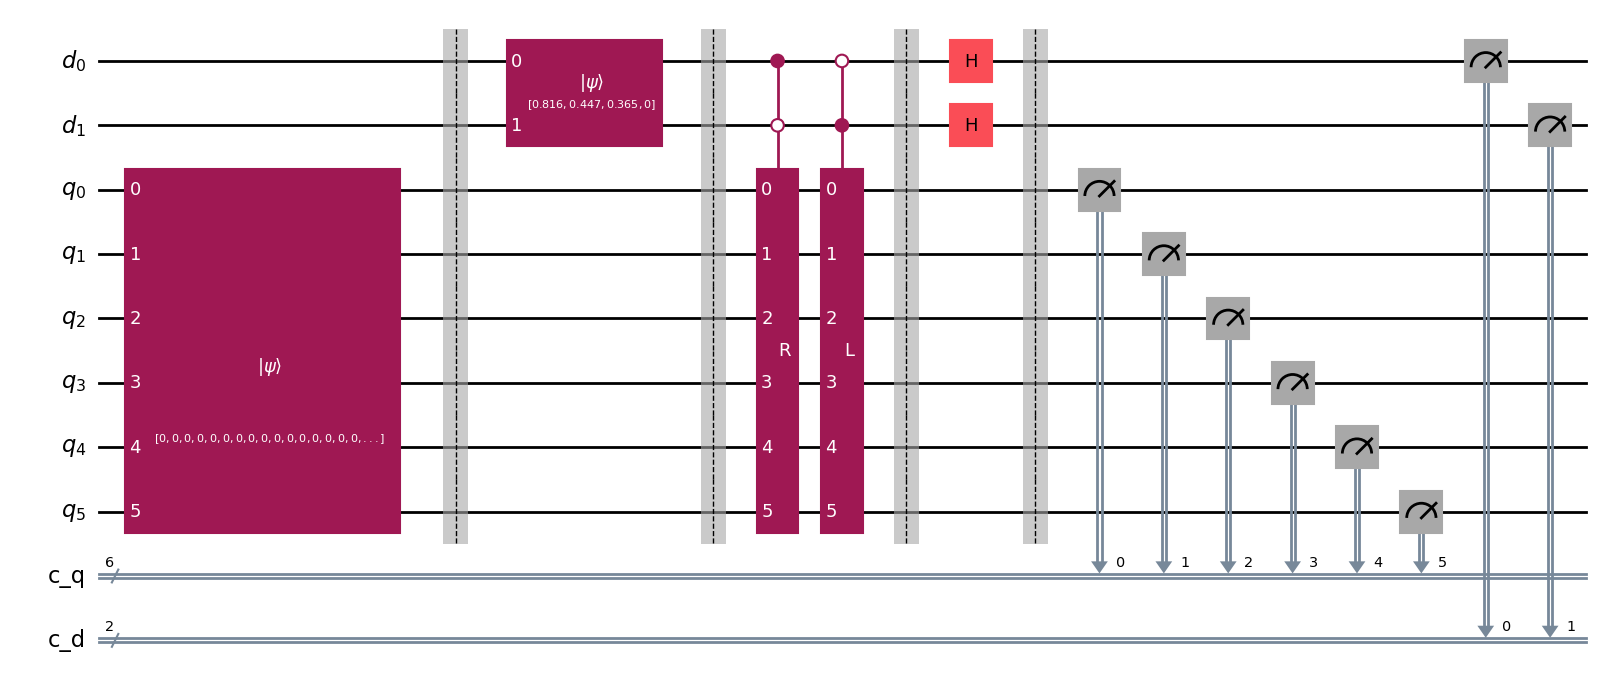

In [8]:
main_qc = concentration_qc.copy()
main_qc.barrier()

main_qc.compose(amp_qc, inplace=True)
main_qc.barrier()

main_qc.compose(streaming_qc, inplace=True)
main_qc.barrier()

main_qc.h(d_reg)
main_qc.barrier()

main_qc.measure(q_reg, c_q)
main_qc.measure(d_reg, c_d)

main_qc.draw('mpl')


In [9]:
def simulate_circuit(qc, sim, n_shots):
    compiled_qc = transpile(qc, sim)
    result = sim.run(compiled_qc, shots=n_shots).result() 
    counts = result.get_counts() 

    filtered_counts = Counter()
    for key, val in counts.items():
        try:
            d_state, q_state = key.split(' ') 
        except ValueError:
            continue
        
        if d_state == '00':
            filtered_counts[q_state] += val


    phi_next_step = np.zeros(2**n_q)
    total_filtered_counts = sum(filtered_counts.values())

    if total_filtered_counts > 0:
        for state_str, count in filtered_counts.items():
            idx = int(state_str, 2)
            phi_next_step[idx] = count
        phi_next_step /= total_filtered_counts  
    phi_next_amplitudes = np.sqrt(phi_next_step)
    
    return phi_next_step, phi_next_amplitudes

The simulation was set to `n_shots = 50000` for the accuracy of the measurement.

In [10]:
n_shots = 50000

sim = AerSimulator(max_parallel_threads=2)
# sim = AerSimulator()

In [11]:
next_phi, phi_amp = simulate_circuit(main_qc, sim, n_shots)

print(f'phi(x, 1) :\n{np.round(next_phi, 4)}')

phi(x, 1) :
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1295 0.6683 0.2022 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.    ]


## 5. Simulation

#### 5-a)

The probability amplitudes obtained from the $t = 1$ simulation are used as the new initial state for $t = 2$.

The function `gen_circuit(phi_amp)` reinitializes  the $\ket{q}$ register using `main_qc.initialize(phi_amp, q_reg)`.


In [12]:
def gen_circuit(phi_amp):
    main_qc = qc.copy()

    main_qc.initialize(phi_amp, q_reg)
    main_qc.barrier()

    main_qc.compose(amp_qc, inplace=True)
    main_qc.barrier()

    main_qc.compose(streaming_qc, inplace=True)
    main_qc.barrier()

    main_qc.h(d_reg)
    main_qc.barrier()

    main_qc.measure(q_reg, c_q)
    main_qc.measure(d_reg, c_d)

    return main_qc

In [13]:
main_qc = gen_circuit(phi_amp)
next_phi, phi_amp = simulate_circuit(main_qc, sim, n_shots)

print(f'phi(x, 2) :\n{np.round(next_phi, 4)}')

phi(x, 2) :
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0094 0.1822 0.5112 0.2765 0.0207 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.    ]


#### 5-b)

The process in 5-a is repeated for 20 time steps using a for loop.

At each time step `i`, the function `gen_circuit` builds the circuit, and `simulate_circuit` executes the simulation to obtain
both the distribution (`next_phi`) and the amplitudes (`phi_amp`).

Each result (`next_phi`) is stored sequentially in the list `phi_history`.

In [14]:
phi_history = []
phi_history.append(initial_phi)

phi_amp = initial_phi.copy()

for i in range(20):
    main_qc = gen_circuit(phi_amp)
    next_phi, phi_amp = simulate_circuit(main_qc, sim, n_shots)
    print(f'Timestep {i+1} finished')

    phi_history.append(next_phi)

Timestep 1 finished
Timestep 2 finished
Timestep 3 finished
Timestep 4 finished
Timestep 5 finished
Timestep 6 finished
Timestep 7 finished
Timestep 8 finished
Timestep 9 finished
Timestep 10 finished
Timestep 11 finished
Timestep 12 finished
Timestep 13 finished
Timestep 14 finished
Timestep 15 finished
Timestep 16 finished
Timestep 17 finished
Timestep 18 finished
Timestep 19 finished
Timestep 20 finished


#### 5-c)

Among the data stored in `phi_history`, 
the distributions corresponding to $t = 0, 1, 2, 20$(`phi_history[0]`, `phi_history[1]`, `phi_history[2]`, `phi_history[20]`)  
are plotted on a single graph using `matplotlib.pyplot`.

Through this process, a one-dimensional fluid simulation using the QLBM framework was successfully implemented. 
Increasing the number of measurement shots can further improve accuracy, 
and by experimenting with various initial conditions and parameters, 
different fluid characteristics can be explored.

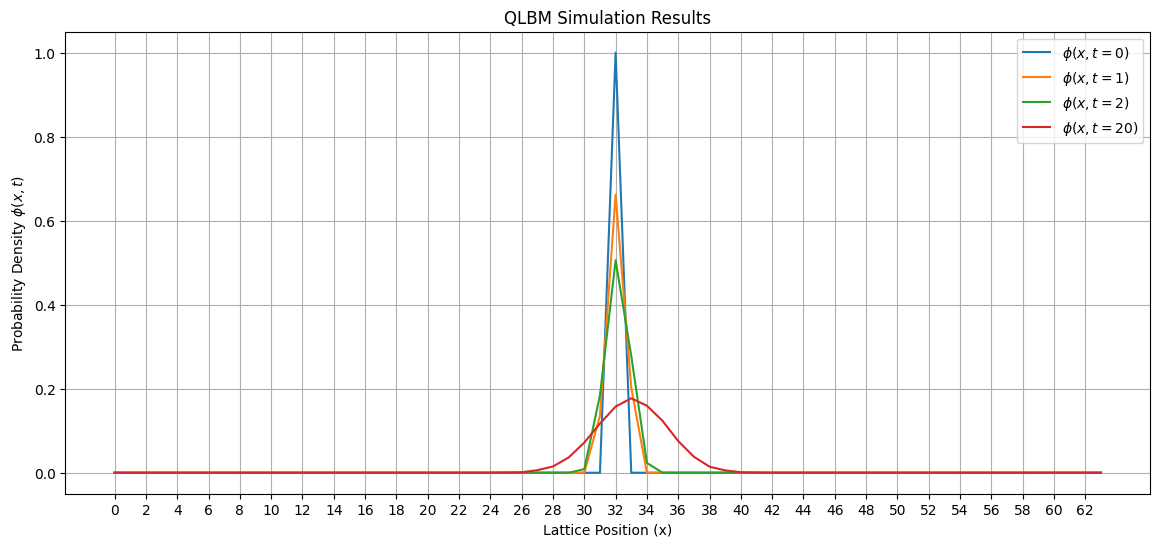

In [15]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(2**n_q)

for i in range(len(phi_history)):
    if i in [0, 1, 2, 20]:
        plt.plot(x_axis, phi_history[i], '-', label=f'$\phi(x, t={i})$')

plt.xticks(np.arange(0, 64, 2))
plt.title(f'QLBM Simulation Results')
plt.xlabel('Lattice Position (x)')
plt.ylabel('Probability Density $\phi(x, t)$')
plt.legend()
plt.grid(True)

plt.show()